In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, f1_score, 
                             precision_score, recall_score)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
## Import data split and preprocessed in attached notebooks
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')

In [3]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [4]:
def score_retriever(true_results, predictions):
    precision = precision_score(true_results, predictions, average='weighted') * 100
    recall = recall_score(true_results, predictions, average='weighted') * 100
    accuracy = accuracy_score(true_results, predictions) * 100
    f1 = f1_score(true_results, predictions, average='weighted') * 100
    return precision, recall, accuracy, f1

In [5]:
algorithm_scores = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'Accuracy', 'F1_Score'])

### Decision Tree

In [6]:
dt_classifier_default_params = DecisionTreeClassifier(random_state=42)
dt_classifier_baseline_score = np.mean(cross_val_score(dt_classifier_default_params,
                                                       X_train, y_train.values.ravel(), cv=3))
dt_classifier_baseline_score

0.5427860580594885

In [7]:
dt_classifier_default_params.fit(X_train, y_train.values.ravel())
dt_classifier_baseline_predictions = dt_classifier_default_params.predict(X_test)
print('Test Scores')
print(f'Decision Tree Baseline Precision: {score_retriever(y_test, dt_classifier_baseline_predictions)[0]}')
print(f'Decision Tree Baseline Recall: {score_retriever(y_test, dt_classifier_baseline_predictions)[1]}')
print(f'Decision Tree Baseline Accuracy: {score_retriever(y_test, dt_classifier_baseline_predictions)[2]}')
print(f'Decision Tree Baseline F1: {score_retriever(y_test, dt_classifier_baseline_predictions)[3]}')

Test Scores
Decision Tree Baseline Precision: 70.8802531462495
Decision Tree Baseline Recall: 54.29276749707911
Decision Tree Baseline Accuracy: 54.29276749707911
Decision Tree Baseline F1: 60.6990068570941


In [8]:
algorithm_scores = algorithm_scores.append({'Model': 'Decision Tree Baseline',
                                            'Precision': score_retriever(y_test, dt_classifier_baseline_predictions)[0],
                                            'Recall': score_retriever(y_test, dt_classifier_baseline_predictions)[1],
                                            'Accuracy': score_retriever(y_test, dt_classifier_baseline_predictions)[2],
                                            'F1_Score': score_retriever(y_test, dt_classifier_baseline_predictions)[3]},
                                                        ignore_index=True)

In [9]:
print(classification_report(y_test, dt_classifier_baseline_predictions))

              precision    recall  f1-score   support

           0       0.06      0.32      0.10      2232
           1       0.19      0.25      0.22      7874
           2       0.84      0.61      0.70     42960

    accuracy                           0.54     53066
   macro avg       0.36      0.39      0.34     53066
weighted avg       0.71      0.54      0.61     53066



In [10]:
dt_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [11]:
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=3, n_jobs=-1)
dt_grid_search = dt_grid_search.fit(X_train, y_train.values.ravel())

In [12]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [13]:
dt_classifier_best_params = DecisionTreeClassifier(criterion=dt_grid_search.best_params_['criterion'],
                                                   max_depth=dt_grid_search.best_params_['max_depth'],
                                                   min_samples_leaf=dt_grid_search.best_params_['min_samples_leaf'],
                                                   min_samples_split=dt_grid_search.best_params_['min_samples_split'],
                                                   random_state=42)

In [14]:
dt_classifier_best_params.fit(X_train, y_train)
dt_best_parameters_predictions = dt_classifier_best_params.predict(X_test)
print('Test Scores')
print(f'Decision Tree Tuned Precision: {score_retriever(y_test, dt_best_parameters_predictions)[0]}')
print(f'Decision Tree Tuned Recall: {score_retriever(y_test, dt_best_parameters_predictions)[1]}')
print(f'Decision Tree Tuned Accuracy: {score_retriever(y_test, dt_best_parameters_predictions)[2]}')
print(f'Decision Tree Tuned F1: {score_retriever(y_test, dt_best_parameters_predictions)[3]}')

Test Scores
Decision Tree Tuned Precision: 70.87898428160364
Decision Tree Tuned Recall: 54.27203859344968
Decision Tree Tuned Accuracy: 54.272038593449665
Decision Tree Tuned F1: 60.68094725239429


In [15]:
algorithm_scores = algorithm_scores.append({'Model': 'Decision Tree Tuned',
                                            'Precision': score_retriever(y_test, dt_best_parameters_predictions)[0],
                                            'Recall': score_retriever(y_test, dt_best_parameters_predictions)[1],
                                            'Accuracy': score_retriever(y_test, dt_best_parameters_predictions)[2],
                                            'F1_Score': score_retriever(y_test, dt_best_parameters_predictions)[3]},
                                                        ignore_index=True)

In [16]:
print(classification_report(y_test, dt_best_parameters_predictions))

              precision    recall  f1-score   support

           0       0.06      0.32      0.10      2232
           1       0.19      0.25      0.21      7874
           2       0.84      0.61      0.70     42960

    accuracy                           0.54     53066
   macro avg       0.36      0.39      0.34     53066
weighted avg       0.71      0.54      0.61     53066



### Random Forest 

In [17]:
rf_classifier_default_params = RandomForestClassifier(random_state=42)
rf_classifier_baseline_score = np.mean(cross_val_score(rf_classifier_default_params,
                                                       X_train, y_train.values.ravel(), cv=3))
rf_classifier_baseline_score

0.5440132139315846

In [18]:
rf_classifier_default_params.fit(X_train, y_train.values.ravel())
rf_classifier_baseline_predictions = rf_classifier_default_params.predict(X_test)
print('Test Scores')
print(f'Random Forest Baseline Precision: {score_retriever(y_test, rf_classifier_baseline_predictions)[0]}')
print(f'Random Forest Baseline Recall: {score_retriever(y_test, rf_classifier_baseline_predictions)[1]}')
print(f'Random Forest Baseline Accuracy: {score_retriever(y_test, rf_classifier_baseline_predictions)[2]}')
print(f'Random Forest Baseline F1: {score_retriever(y_test, rf_classifier_baseline_predictions)[3]}')

Test Scores
Random Forest Baseline Precision: 70.94149156263916
Random Forest Baseline Recall: 54.69980778652999
Random Forest Baseline Accuracy: 54.69980778652999
Random Forest Baseline F1: 61.00714415776275


In [19]:
algorithm_scores = algorithm_scores.append({'Model': 'Random Forest Baseline',
                                            'Precision': score_retriever(y_test, rf_classifier_baseline_predictions)[0],
                                            'Recall': score_retriever(y_test, rf_classifier_baseline_predictions)[1],
                                            'Accuracy': score_retriever(y_test, rf_classifier_baseline_predictions)[2],
                                            'F1_Score': score_retriever(y_test, rf_classifier_baseline_predictions)[3]},
                                                        ignore_index=True)

In [20]:
print(classification_report(y_test, rf_classifier_baseline_predictions))

              precision    recall  f1-score   support

           0       0.06      0.32      0.10      2232
           1       0.20      0.25      0.22      7874
           2       0.84      0.61      0.71     42960

    accuracy                           0.55     53066
   macro avg       0.36      0.39      0.34     53066
weighted avg       0.71      0.55      0.61     53066



In [21]:
rf_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100]
}

In [22]:
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search = rf_grid_search.fit(X_train, y_train.values.ravel())

C:\Users\benja\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\benja\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\benja\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\benja\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\benja\anaconda3\lib\site-packages

In [23]:
rf_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [24]:
rf_classifier_best_params = RandomForestClassifier(criterion=rf_grid_search.best_params_['criterion'],
                                                   max_depth=rf_grid_search.best_params_['max_depth'],
                                                   min_samples_leaf=rf_grid_search.best_params_['min_samples_leaf'],
                                                   min_samples_split=rf_grid_search.best_params_['min_samples_split'],
                                                   n_estimators=rf_grid_search.best_params_['n_estimators'],
                                                   random_state=42)

In [25]:
rf_classifier_best_params.fit(X_train, y_train.values.ravel())
rf_best_parameters_predictions = rf_classifier_best_params.predict(X_test)
print('Test Scores')
print(f'Random Forest Tuned Precision: {score_retriever(y_test, rf_best_parameters_predictions)[0]}')
print(f'Random Forest Tuned Recall: {score_retriever(y_test, rf_best_parameters_predictions)[1]}')
print(f'Random Forest Tuned Accuracy: {score_retriever(y_test, rf_best_parameters_predictions)[2]}')
print(f'Random Forest Tuned F1: {score_retriever(y_test, rf_best_parameters_predictions)[3]}')

<ipython-input-25-969c89083e59>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier_best_params.fit(X_train, y_train)


Test Scores
Random Forest Tuned Precision: 71.34048440544412
Random Forest Tuned Recall: 54.125051822259074
Random Forest Tuned Accuracy: 54.125051822259074
Random Forest Tuned F1: 60.6747613656049


In [26]:
algorithm_scores = algorithm_scores.append({'Model': 'Random Forest Tuned',
                                            'Precision': score_retriever(y_test, rf_best_parameters_predictions)[0],
                                            'Recall': score_retriever(y_test, rf_best_parameters_predictions)[1],
                                            'Accuracy': score_retriever(y_test, rf_best_parameters_predictions)[2],
                                            'F1_Score': score_retriever(y_test, rf_best_parameters_predictions)[3]},
                                                        ignore_index=True)

In [27]:
print(classification_report(y_test, rf_best_parameters_predictions))

              precision    recall  f1-score   support

           0       0.06      0.33      0.11      2232
           1       0.20      0.26      0.23      7874
           2       0.84      0.60      0.70     42960

    accuracy                           0.54     53066
   macro avg       0.37      0.40      0.35     53066
weighted avg       0.71      0.54      0.61     53066



In [28]:
rf_feature_importance_dict = dict(zip(X_train.columns, rf_classifier_best_params.feature_importances_))

In [29]:
dummied_categories = ['steward', 'guards', 'borough']
for name in dummied_categories:
    category_sum = sum([value for key, value in rf_feature_importance_dict.items() if name in key])
    remove_keys = [key for key in rf_feature_importance_dict.keys() if name in key]
    for key in remove_keys:
        rf_feature_importance_dict.pop(key)
    rf_feature_importance_dict[name] = category_sum

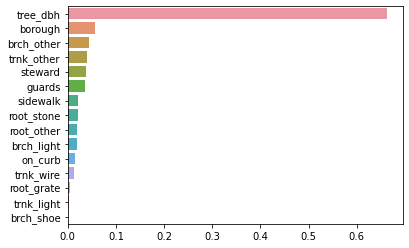

In [30]:
importances = pd.Series(rf_feature_importance_dict.values(), 
                        index=rf_feature_importance_dict.keys()).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index);

### eXtreme Gradient Boosting

In [31]:
xgb_classifier_default_params = XGBClassifier(random_state=42, use_label_encoder=False)
xgb_classifier_baseline_score = np.mean(cross_val_score(xgb_classifier_default_params,
                                                        X_train, y_train.values.ravel(), cv=3))
xgb_classifier_baseline_score

[07:01:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:03:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:04:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5178571890881507

In [32]:
xgb_classifier_default_params.fit(X_train, y_train.values.ravel())
xgb_classifier_baseline_predictions = xgb_classifier_default_params.predict(X_test)
print('Test Scores')
print(f'eXtreme Gradient Boost Baseline Precision: {score_retriever(y_test, xgb_classifier_baseline_predictions)[0]}')
print(f'eXtreme Gradient Boost Baseline Recall: {score_retriever(y_test, xgb_classifier_baseline_predictions)[1]}')
print(f'eXtreme Gradient Boost Baseline Accuracy: {score_retriever(y_test, xgb_classifier_baseline_predictions)[2]}')
print(f'eXtreme Gradient Boost Baseline F1: {score_retriever(y_test, xgb_classifier_baseline_predictions)[3]}')

[07:05:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Scores
eXtreme Gradient Boost Baseline Precision: 71.80843557775046
eXtreme Gradient Boost Baseline Recall: 61.875777333886106
eXtreme Gradient Boost Baseline Accuracy: 61.875777333886106
eXtreme Gradient Boost Baseline F1: 66.04130907945893


In [33]:
algorithm_scores = algorithm_scores.append({'Model': 'XGBoost Baseline',
                                            'Precision': score_retriever(y_test, xgb_classifier_baseline_predictions)[0],
                                            'Recall': score_retriever(y_test, xgb_classifier_baseline_predictions)[1],
                                            'Accuracy': score_retriever(y_test, xgb_classifier_baseline_predictions)[2],
                                            'F1_Score': score_retriever(y_test, xgb_classifier_baseline_predictions)[3]},
                                                        ignore_index=True)

In [34]:
print(classification_report(y_test, xgb_classifier_baseline_predictions))

              precision    recall  f1-score   support

           0       0.07      0.33      0.12      2232
           1       0.23      0.19      0.21      7874
           2       0.84      0.71      0.77     42960

    accuracy                           0.62     53066
   macro avg       0.38      0.41      0.37     53066
weighted avg       0.72      0.62      0.66     53066



In [35]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'n_estimators': [100],
    'subsample': [0.5, 0.7]
}

In [36]:
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False),
                               xgb_param_grid, scoring='accuracy', cv=3)
xgb_grid_search = xgb_grid_search.fit(X_train, y_train.values.ravel())

[07:08:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:09:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:11:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:12:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [37]:
xgb_grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.7}

In [38]:
xgb_classifier_best_params = XGBClassifier(learning_rate=xgb_grid_search.best_params_['learning_rate'],
                                           max_depth=xgb_grid_search.best_params_['max_depth'],
                                           min_child_weight=xgb_grid_search.best_params_['min_child_weight'],
                                           n_estimators=xgb_grid_search.best_params_['n_estimators'],
                                           subsample=xgb_grid_search.best_params_['subsample'],
                                           random_state=42, use_label_encoder=False)

In [39]:
xgb_classifier_best_params.fit(X_train, y_train)
xgb_best_parameters_predictions = xgb_classifier_best_params.predict(X_test)
print('Test Scores')
print(f'eXtreme Gradient Boost Tuned Precision: {score_retriever(y_test, xgb_best_parameters_predictions)[0]}')
print(f'eXtreme Gradient Boost Tuned Recall: {score_retriever(y_test, xgb_best_parameters_predictions)[1]}')
print(f'eXtreme Gradient Boost Tuned Accuracy: {score_retriever(y_test, xgb_best_parameters_predictions)[2]}')
print(f'eXtreme Gradient Boost Tuned F1: {score_retriever(y_test, xgb_best_parameters_predictions)[3]}')

[07:47:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [45]:
algorithm_scores = algorithm_scores.append({'Model': 'XGBoost Tuned',
                                            'Precision': score_retriever(y_test, xgb_best_parameters_predictions)[0],
                                            'Recall': score_retriever(y_test, xgb_best_parameters_predictions)[1],
                                            'Accuracy': score_retriever(y_test, xgb_best_parameters_predictions)[2],
                                            'F1_Score': score_retriever(y_test, xgb_best_parameters_predictions)[3]},
                                                        ignore_index=True)

In [46]:
algorithm_scores

,Model,Precision,Recall,Accuracy,F1_Score
0,Decision Tree Baseline,70.880253,54.292767,54.292767,60.699007
1,Decision Tree Tuned,70.878984,54.272039,54.272039,60.680947
2,Random Forest Baseline,70.941492,54.699808,54.699808,61.007144
3,Random Forest Tuned,71.340484,54.125052,54.125052,60.674761
4,XGBoost Baseline,71.808436,61.875777,61.875777,66.041309
5,XGBoost Tuned,72.113548,62.194249,62.194249,66.361805
